In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from mobius import VirtualTarget, ForceField

In [2]:
class PBIL(object):
    def __init__(self, peptide_length, population_size=96, n_best=1,
                 learning_rate=0.3, mut_prob=0.1, mut_shift=0.05, seed=None):
        self._AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                     'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        # Random generation
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

        # Initialize probability vectors
        n_amino_acids = len(self._AA1)
        self._peptide_length = peptide_length
        init_probability = 1. / n_amino_acids
        self._prob_vector = np.zeros(shape=(peptide_length, n_amino_acids)) + init_probability

        # PBIL parameters
        self._n_best = n_best
        self._learning_rate = learning_rate
        self._mut_prob = mut_prob
        self._mut_shift = mut_shift
        self._population_size = population_size
        
        # Elitism
        self._best_score = 9999

    def sample(self):
        ind = [self._rng.choice(self._AA1, p=self._prob_vector[i]) for i in range(self._peptide_length)]
        return (ind)

    def generate(self, ind_init):
        return [ind_init(self.sample()) for _ in range(self._population_size)]

    def update(self, population, scores=None):
        sigma = 0.25
        
        if scores is None:
            scores = np.array([ind.fitness.values[0] for ind in population])

        best_peptide_indices = np.argsort(np.ravel(scores))[:self._n_best]
        best_peptides = np.array(population)[best_peptide_indices]
        
        for i in range(self._peptide_length):
            if self._n_best > 1:
                unique_amino_acids = np.flip(best_peptides[:,i])
                frequencies = np.array([1] * len(unique_amino_acids))          
            else:
                unique_amino_acids = [best_peptides[0][i]]
                frequencies = [1.]
            
            for unique_amino_acid, frequency in zip(unique_amino_acids, frequencies):
                j = self._AA1.index(unique_amino_acid)
                
                # Update the probability vector (exploitation)
                self._prob_vector[i, j] *= 1.0 - self._learning_rate
                self._prob_vector[i, j] += frequency * self._learning_rate

                # Mutate the probability vector (exploration)
                if self._rng.uniform() < self._mut_prob:
                    self._prob_vector[i, j] *= 1.0 - self._mut_shift
                    self._prob_vector[i, j] += self._rng.uniform() * self._mut_shift
            
            # Normalize vector
            self._prob_vector[i] /= np.sum(self._prob_vector[i])


def evaluate(individual):
    return vt.score_peptides([''.join(individual)])[0],

In [3]:
def plot_logbook(logbook, minimum_score):
    gen = logbook.select("gen")
    fit_mins = logbook.select("min")
    size_avgs = logbook.select("avg")

    fig, ax1 = plt.subplots(figsize=(15, 5))
    line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")
    
    line3 = ax1.plot(np.linspace(0, np.max(gen), np.max(gen)), [minimum_score] * np.max(gen), 
             '--', color='green', label='Target fitness')

    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, size_avgs, "r-", label="Average Fitness")
    ax2.set_ylabel("Size", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")

    lns = line1 + line2 + line3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="upper right")
    
    ax1.set_ylim([0, 12])
    ax2.set_ylim([0, 20])

    plt.show()

# Initial test

In [4]:
NLEN = 6

ff = ForceField()
vt = VirtualTarget(ff)
vt.generate_random_target_sequence(NLEN)
vt.generate_pharmacophore_from_target_sequence('AAAAAA', solvent_exposures=[0] * 6)
print(vt.target_sequence())
print(vt.score_peptides([vt.target_sequence()]))
minimum_score = vt.score_peptides([vt.target_sequence()])[0]

AAAAAA
[0.]


/home/eberhardt/Applications/miniconda3/envs/mm/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eberhardt/Applications/miniconda3/envs/mm/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	std    	min    	max    
0  	96    	17.0453	2.83679	10.2491	23.4193
1  	96    	14.0938	3.22894	7.64937	21.6055
2  	96    	10.9096	2.66712	4.59812	16.0443
3  	96    	9.13801	2.08561	2.98018	13.6248
4  	96    	8.27798	2.39228	1.49009	14.7677
5  	96    	6.86405	2.09665	1.90108	10.8492
6  	96    	5.79316	1.81948	1.0791 	9.20445
7  	96    	5.23299	1.75487	0.950538	9.31065
8  	96    	5.08254	1.68037	1.49009 	9.81368
9  	96    	4.11829	1.48565	1.0791  	8.1401 


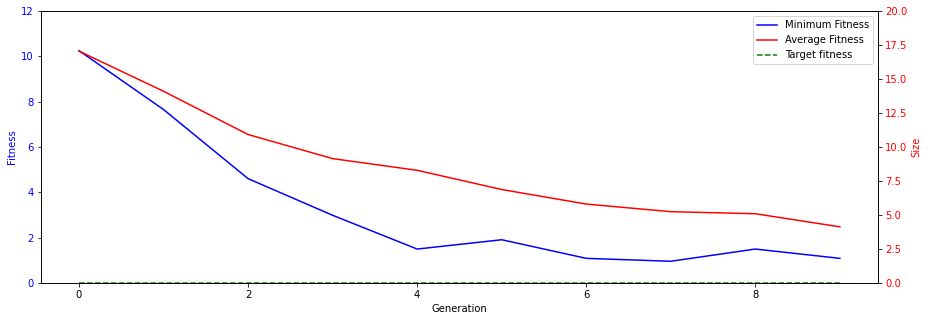

[['G', 'A', 'A', 'A', 'A', 'A'], ['P', 'A', 'A', 'P', 'A', 'A'], ['P', 'A', 'A', 'A', 'A', 'G'], ['P', 'A', 'A', 'G', 'A', 'A'], ['P', 'P', 'A', 'P', 'A', 'A'], ['P', 'A', 'A', 'P', 'A', 'P'], ['G', 'A', 'A', 'G', 'A', 'A'], ['G', 'A', 'A', 'A', 'A', 'G'], ['G', 'A', 'A', 'P', 'A', 'P'], ['G', 'P', 'P', 'A', 'A', 'A']]


In [7]:
NGEN = 10
NIND = 96

#Initialize the PBIL EDA
pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=20, learning_rate=0.5, mut_prob=0.00)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)
toolbox.register("generate", pbil.generate, creator.Individual)
toolbox.register("update", pbil.update)

# Statistics computation
hof = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=True, halloffame=hof)

plot_logbook(logbook, minimum_score)

print(hof.items)

# Incorporation of more than one best solution using weight

## Repeated peptide sequence

In [ ]:
NLEN = 6

ff = ForceField()
vt = VirtualTarget(ff)
vt.generate_random_target_sequence(NLEN)
vt.generate_pharmacophore_from_target_sequence('AAAAAA', solvent_exposures=[0] * 6)
print(vt.target_sequence())
print(vt.score_peptides([vt.target_sequence()]))
minimum_score = vt.score_peptides([vt.target_sequence()])[0]

In [8]:
NGEN = 20
NIND = 96
learning_rate = 0.20

logbooks = []

for n_best in [1, 5, 10, 20, 48, 96]:
    print(n_best)

    for i in range(100):
        print(i, end=' ')

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=n_best, learning_rate=0.5, mut_prob=0.00)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['n_best'] = n_best
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

1
0 

/home/eberhardt/Applications/miniconda3/envs/mm/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eberhardt/Applications/miniconda3/envs/mm/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

5
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

10
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

20
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42

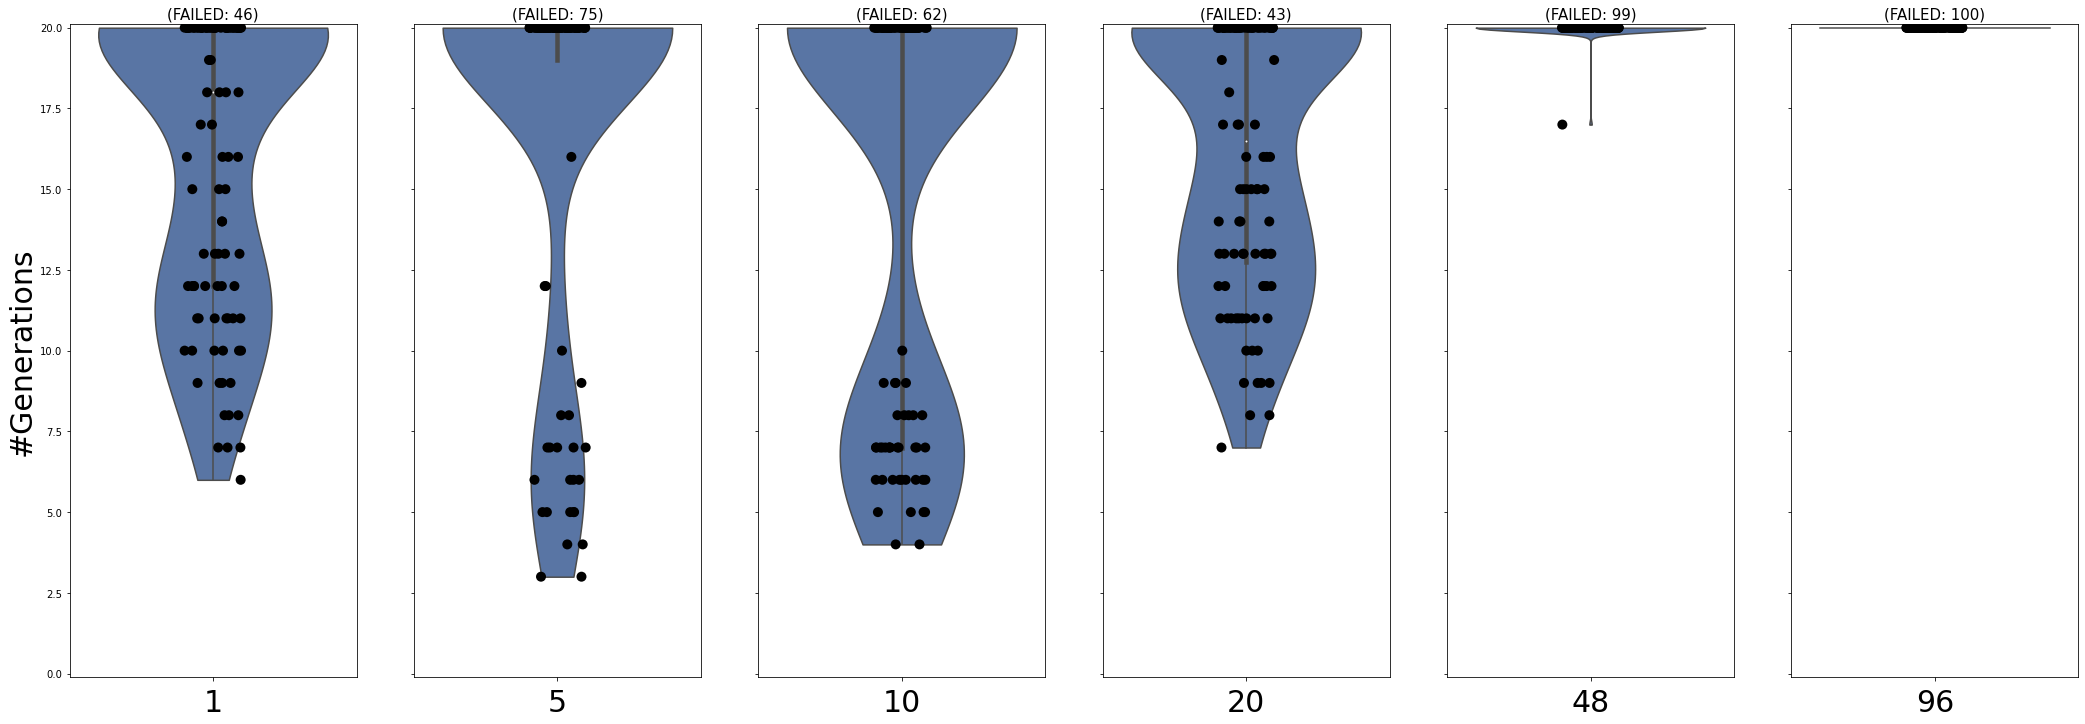

In [9]:
fig, axarr = plt.subplots(1, 6, figsize=(6*6, 12), sharey=True)

axarr[0].set_ylabel('#Generations', fontsize=30)

i = 0

for n_best_label, n_best_group in logbooks.groupby('n_best'):
    gens = []
    failed = 0

    for _, group in n_best_group.groupby('run'):
        best = group.sort_values(by=['min', 'gen']).iloc[0]
        gen = best['gen'] + 1 if best['min'] == 0 else NGEN
        gens.append(gen)
        
        if gen == NGEN:
            failed += 1
        
    sns.set_theme(style=None)
    sns.violinplot(y=gens, cut=0, ax=axarr[i])
    sns.stripplot(y=gens, color='black', size=10, ax=axarr[i])
    axarr[i].set_title('(FAILED: %d)' % failed, fontsize=15)
    axarr[i].set_ylim([-0.1, NGEN + .1])
    axarr[i].set_xlabel(n_best_label, fontsize=30)
    
    i += 1

plt.savefig('figure_peptide_AAAAAA_n_best.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
scores = np.array([1, 1, 1, 1])
best_score = 1

norm_scores = scores - best_score
print(norm_scores)
norm_scores =  norm_scores / (np.max(scores) - best_score)

[0 0 0 0]


/tmp/ipykernel_503549/815174386.py:6: RuntimeWarning: invalid value encountered in true_divide
  norm_scores =  norm_scores / (np.max(scores) - best_score)


In [17]:
norm_scores

array([nan, nan, nan, nan])